# Plot posterior Ne skyline estimates 

This notebook is for plotting parameter values and tree metrics taken from the posterior rather than the summary tree

In [295]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lhmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [296]:
import pymc3

In [297]:
from datetime import date
current_date = str(date.today())

In [298]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [299]:
def return_most_recent_tip(tree):
    for k in tree.Objects: 
        if k.branchType == "leaf":
            if k.traits['height'] == 0:
                date = float(k.name.split("|")[1])
    return(k, date)

In [314]:
# old log file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "log":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.log"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "log":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.log"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "log": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.log"}
skyline_human_off = {"label": "h5nx-GsGd-1996-Neprior", "mig_direction":"forwards in time",
                     "log": "beast-runs/2023-03-08-mascot-skyline-3deme/5-year-region-host-GsGd-only-h5nx-1996-Neprior/combined-it1-it3-2023-08-24.log", 
                    "tree":"beast-runs/2023-03-08-mascot-skyline-3deme/5-year-region-host-GsGd-only-h5nx-1996-Neprior/combined-it1-it3-2023-08-24.mcc.tree"}

In [315]:
# new log file and tree paths
Ne_prior_10_year_host = {"label": "h5nx-GsGd-1996-Neprior-10-year-host", 
                     "log": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-10-per-year-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-2023-10-09.log", 
                    "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-10-per-year-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-2023-10-09.mcc.tree"}

No_Ne_prior_10_year_host = {"label": "h5nx-GsGd-1996-10-year-host", 
                     "log": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-10-per-year-host/10-Ne-bins-10-mig-bins/without-last-Ne-prior/combined-noprior-2023-10-09.log",
                      "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-10-per-year-host/10-Ne-bins-10-mig-bins/without-last-Ne-prior/combined-noprior-2023-10-09.mcc.tree"}

Ne_prior_5_region_year_host = {"label": "h5nx-GsGd-1996-Neprior-5-region-year-host", 
                     "log": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-5-per-year-region-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-with-prior-2023-10-09.log",
                      "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-5-per-year-region-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-with-prior-2023-10-09.mcc.tree"}

No_Ne_prior_5_region_year_host = {"label": "h5nx-GsGd-1996-5-region-year-host", 
                     "log": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-5-per-year-region-host/10-Ne-bins-10-mig-bins/without-last-Ne-prior/combined-noprior-2023-10-09.log",
                    "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-5-per-year-region-host/10-Ne-bins-10-mig-bins/without-last-Ne-prior/combined-noprior-2023-10-09.mcc.tree"}

Ne_prior_25_year_host = {"label": "h5nx-GsGd-1996-Neprior-25-year-host", 
                     "log": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-25-per-year-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-Ne-prior-2023-10-09.log", 
                     "tree": "beast-runs/2023-08-17-mascot-skyline-Ne-and-mig/h5nx-1996-to-present-25-per-year-host/10-Ne-bins-10-mig-bins/with-last-Ne-prior/combined-Ne-prior-2023-10-09.mcc.tree"}

In [316]:
to_run = skyline_human_off

log_file_path = to_run['log']
label = to_run['label']
tree = bt.loadNexus(to_run['tree'])

burnin_percent = 0.0

In [317]:
# read in tree height 
youngest_tip_obj, most_recent_tip = return_most_recent_tip(tree)
print(youngest_tip_obj.name, most_recent_tip)

treeheight = tree.treeHeight
age_of_root = float(most_recent_tip) - treeheight
print(treeheight, age_of_root, most_recent_tip)

A/HongKong/97/1998|1998.0|1998-XX-XX|human|China|Hong_Kong|AF102676|EPI_ISL_1189|present|RKKR|0|h5n1|human|human 2023.1397260273973
28.130759286162526 1995.0089667412346 2023.1397260273973


# Plot estimated Ne over time

Since allowing for Ne changes over time appears to be critical to this working, I want to see what is being estimated

In [318]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        for line in infile:
            
            # use the first line to find the migration rate columns
            if "posterior" in line and "#" not in line:
                all_cols = line.split("\t")
                Ne_column_indices = []   # list to store column indices
                Nes_key = {}   # dictionary to store the column index to map to column name
                
                for i in range(len(all_cols)):
                    col = all_cols[i]
                    if "SkylineNe" in col:
                        Ne_column_indices.append(i)
                
                # make an empty dictionary to store Nes and generate dictionary to convert index to name
                for n in Ne_column_indices:
                    name = line.split("\t")[n]
                    deme = name.split(".")[1]   # the syntax here is now SkylineNe.domestic.01 "NeLog.state01" where 0 is deme and 1 is interval 1
                    interval = name.split(".")[2]
                    Nes_key[n] = name
                    Ne_skyline_dict[name] = []

                
            # read in actual parameter estimates and store in dictionary
            elif "#" not in line:
                sample = line.split("\t")[0]
                Ne_skyline_dict["sample"].append(sample)
                
                for index in Ne_column_indices:
                    name = Nes_key[index]
                    Ne_skyline_dict[name].append(line.split("\t")[index])
                    
            else: 
                pass
                    
                
    return(Ne_skyline_dict)

In [327]:
# make a new dataframe collapses the output into long format with columns: deme, interval, sample, NeTau
def generate_collapsed_df(input_df):
    
    new_df = pd.DataFrame()
    
    sample_column = input_df['sample']
    
    for i in input_df.columns.tolist():
        if "SkylineNe" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[2]  # in the newer output, this needs to be changed to 3
            local_series = Ne_df[i].astype(float)

            local_df = pd.DataFrame.from_dict({"sample":sample_column, "Netau": local_series})
            local_df['deme'] = deme
            local_df['interval'] = interval

            new_df = new_df.append(local_df)
            
    return(new_df) 

In [328]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    import pymc3
    import arviz as az

    #ci_95 = az.hdi(posterior_draws, hdi_prob=0.95)
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "SkylineNe" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[2] # in the newer output, this needs to be changed to 3
            local_series = Ne_df[i].astype(float)
            mean_log = local_series.mean()
            mean_linear = 10**mean_log
            hpd = az.hdi(local_series.to_numpy(), 0.95)
            lower_hpd_log = hpd[0]
            lower_hpd_linear = 10**lower_hpd_log
            upper_hpd_log = hpd[1]
            upper_hpd_linear = 10**upper_hpd_log

            local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                               "upper_hpd_log":upper_hpd_log,"lower_hpd_log":[lower_hpd_log], 
                                               "upper_hpd_linear":upper_hpd_linear,"lower_hpd_linear":lower_hpd_linear})

            new_df = new_df.append(local_df)
            
    return(new_df)

In [329]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [330]:
#Ne_skyline

In [331]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
Ne_df.head()

18002


,sample,SkylineNe.domestic.1,SkylineNe.domestic.2,SkylineNe.domestic.3,SkylineNe.domestic.4,SkylineNe.domestic.5,SkylineNe.domestic.6,SkylineNe.domestic.7,SkylineNe.domestic.8,SkylineNe.domestic.9,...,SkylineNe.wild.52,SkylineNe.wild.53,SkylineNe.wild.54,SkylineNe.wild.55,SkylineNe.wild.56,SkylineNe.wild.57,SkylineNe.wild.58,SkylineNe.wild.59,SkylineNe.wild.60,SkylineNe.wild.61
0,0,-1.0322334000339368,-0.348634542183736,0.3486669895194179,2.0241872481975958,1.5944141097546172,1.863776514224939,2.0181606436231188,1.5122749542710023,2.0238898769719444,...,1.3448666809872392,1.4746077062858796,1.255647472244161,0.6206645042447144,-0.6189788097211212,0.6222031383826527,-0.22815346720544374,-1.3920504666380507,-2.0480444053043114,-3.0273425061579577
1,5000,0.24887287170966976,-0.006744264489292285,0.23947475633372542,2.1129543742764385,1.5901795746715721,2.0275899700513063,1.5936492278237253,1.6886677643847694,2.352171970395141,...,0.9485614347842455,1.1967289751243169,0.8567130938155074,0.43485549132619394,-0.49498847305226823,-0.6384354668127714,-0.6101408009120005,-1.5976562852983287,-1.8653822282176475,-2.551309695784522
2,10000,0.6580665655554592,0.0769042702237662,1.1683739733887732,2.0204763324301274,2.1426413569037708,1.7898772857702396,1.5593875292157788,1.7876448921761254,2.3498975162745683,...,1.2736998796642112,1.5510177282233444,0.8695243205746097,1.2857990890978572,0.07224974425857636,-0.6591876436123044,-0.5020029261665887,-0.6442614128861108,-1.9026184107106976,-2.516814837138509
3,15000,-0.008218341747007928,0.1927030040096434,0.4860498729678758,1.8461695940036162,2.4717319822135653,2.339259584363106,1.7720326125492216,1.6442734697819137,2.377113332979695,...,0.7334115194772687,0.9136480209061578,0.26325498984573575,0.4642173935138823,0.08372677836642861,-0.6071174833531842,-0.5804054605577053,-1.3711280639901189,-1.5834886720563275,-2.598655190739845
4,20000,-0.09328200363703498,-0.008975231444865926,0.5982075328014933,1.6216812535574678,1.8811385455402623,2.768496240120318,1.5760290491660782,1.7254164379405408,2.5788014200575473,...,0.08425378685335955,0.8531941431252484,0.3474713593724154,-0.1471020514708809,-0.3683071014013754,-0.6981411276981832,-0.7351280572870355,-1.1119274239331298,-1.6122483147660582,-2.732905085981436


In [332]:
Ne_df.columns = Ne_df.columns.str.replace(".state0.", "_domestic_")
Ne_df.columns = Ne_df.columns.str.replace(".state1.", "_human_")
Ne_df.columns = Ne_df.columns.str.replace(".state2.", "_wild_")
Ne_df.head()

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/287054823.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Ne_df.columns = Ne_df.columns.str.replace(".state0.", "_domestic_")
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/287054823.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  Ne_df.columns = Ne_df.columns.str.replace(".state1.", "_human_")
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/287054823.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  Ne_df.columns = Ne_df.columns.str.replace(".state2.", "_wild_")


,sample,SkylineNe.domestic.1,SkylineNe.domestic.2,SkylineNe.domestic.3,SkylineNe.domestic.4,SkylineNe.domestic.5,SkylineNe.domestic.6,SkylineNe.domestic.7,SkylineNe.domestic.8,SkylineNe.domestic.9,...,SkylineNe.wild.52,SkylineNe.wild.53,SkylineNe.wild.54,SkylineNe.wild.55,SkylineNe.wild.56,SkylineNe.wild.57,SkylineNe.wild.58,SkylineNe.wild.59,SkylineNe.wild.60,SkylineNe.wild.61
0,0,-1.0322334000339368,-0.348634542183736,0.3486669895194179,2.0241872481975958,1.5944141097546172,1.863776514224939,2.0181606436231188,1.5122749542710023,2.0238898769719444,...,1.3448666809872392,1.4746077062858796,1.255647472244161,0.6206645042447144,-0.6189788097211212,0.6222031383826527,-0.22815346720544374,-1.3920504666380507,-2.0480444053043114,-3.0273425061579577
1,5000,0.24887287170966976,-0.006744264489292285,0.23947475633372542,2.1129543742764385,1.5901795746715721,2.0275899700513063,1.5936492278237253,1.6886677643847694,2.352171970395141,...,0.9485614347842455,1.1967289751243169,0.8567130938155074,0.43485549132619394,-0.49498847305226823,-0.6384354668127714,-0.6101408009120005,-1.5976562852983287,-1.8653822282176475,-2.551309695784522
2,10000,0.6580665655554592,0.0769042702237662,1.1683739733887732,2.0204763324301274,2.1426413569037708,1.7898772857702396,1.5593875292157788,1.7876448921761254,2.3498975162745683,...,1.2736998796642112,1.5510177282233444,0.8695243205746097,1.2857990890978572,0.07224974425857636,-0.6591876436123044,-0.5020029261665887,-0.6442614128861108,-1.9026184107106976,-2.516814837138509
3,15000,-0.008218341747007928,0.1927030040096434,0.4860498729678758,1.8461695940036162,2.4717319822135653,2.339259584363106,1.7720326125492216,1.6442734697819137,2.377113332979695,...,0.7334115194772687,0.9136480209061578,0.26325498984573575,0.4642173935138823,0.08372677836642861,-0.6071174833531842,-0.5804054605577053,-1.3711280639901189,-1.5834886720563275,-2.598655190739845
4,20000,-0.09328200363703498,-0.008975231444865926,0.5982075328014933,1.6216812535574678,1.8811385455402623,2.768496240120318,1.5760290491660782,1.7254164379405408,2.5788014200575473,...,0.08425378685335955,0.8531941431252484,0.3474713593724154,-0.1471020514708809,-0.3683071014013754,-0.6981411276981832,-0.7351280572870355,-1.1119274239331298,-1.6122483147660582,-2.732905085981436


In [333]:
Ne_collapsed = generate_collapsed_df(Ne_df)
Ne_collapsed.head()

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/1108288177.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


,sample,Netau,deme,interval
0,0,-1.032233,domestic,1
1,5000,0.248873,domestic,1
2,10000,0.658067,domestic,1
3,15000,-0.008218,domestic,1
4,20000,-0.093282,domestic,1


In [334]:
Ne_summary = generate_summary_df(Ne_df)
Ne_summary.head()

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2138967011.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199
0,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013
0,domestic,3,0.917302,8.266128,1.696091,0.154208,49.669623,1.426292
0,domestic,4,1.581236,38.127256,2.294904,0.906284,197.198872,8.059062
0,domestic,5,2.046497,111.300570,2.865129,1.223238,733.042957,16.720068


### add in dates and convert the interval into something more interpretable

I estimated 10 intervals. According to my discussions with Nicola from this slack thread (https://bedfordlab.slack.com/archives/C01MGKPE5L5/p1691007860606489), these bins represent splitting the tree into 10 bins based on the overall tree height. Above, I traverse the tree to find the youngest tip and the age of the root. Now, I should be able to just divide that into 10 intervals. According to this tutorial, and the fact that Nicola's software has skygrid in it rather than skyline, I am pretty sure that the times here represent back in by year from date of youngest tip. 

In [337]:
n_intervals = len(set(Ne_summary['interval'].tolist()))
print(n_intervals)

61


In [338]:
interval_size = (float(most_recent_tip) - float(age_of_root))/n_intervals
print(interval_size)

0.461159988297748


In [339]:
Ne_summary['years_from_present'] = (Ne_summary['interval'].astype(float)*interval_size) - interval_size
Ne_summary['date'] = float(most_recent_tip) - Ne_summary['years_from_present']
Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.00000,2023.139726
0,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.46116,2022.678566
0,domestic,3,0.917302,8.266128,1.696091,0.154208,49.669623,1.426292,0.92232,2022.217406
0,domestic,4,1.581236,38.127256,2.294904,0.906284,197.198872,8.059062,1.38348,2021.756246
0,domestic,5,2.046497,111.300570,2.865129,1.223238,733.042957,16.720068,1.84464,2021.295086


In [340]:
Ne_collapsed['years_from_present'] = (Ne_collapsed['interval'].astype(float)*interval_size) - interval_size
Ne_collapsed['date'] = float(most_recent_tip) - Ne_collapsed['years_from_present']
Ne_collapsed.head()

,sample,Netau,deme,interval,years_from_present,date
0,0,-1.032233,domestic,1,0.0,2023.139726
1,5000,0.248873,domestic,1,0.0,2023.139726
2,10000,0.658067,domestic,1,0.0,2023.139726
3,15000,-0.008218,domestic,1,0.0,2023.139726
4,20000,-0.093282,domestic,1,0.0,2023.139726


/Users/lhmoncla/miniconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


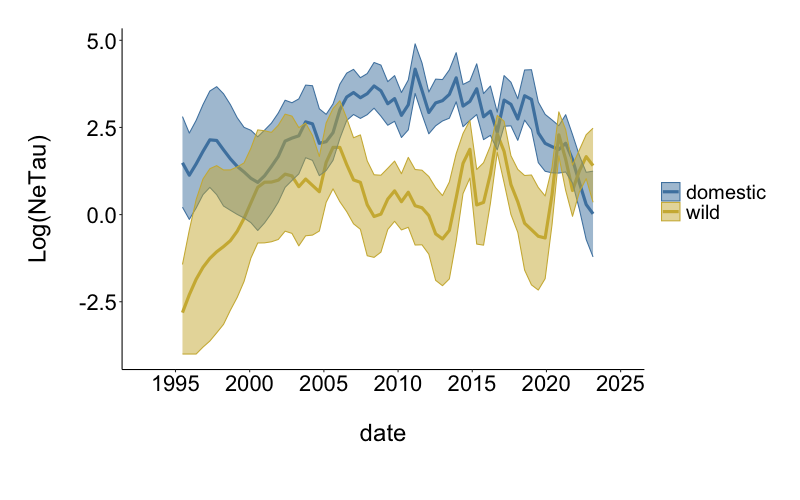

In [341]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2025,5), limits=c(1993,2025))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [342]:
Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.00000,2023.139726
0,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.46116,2022.678566
0,domestic,3,0.917302,8.266128,1.696091,0.154208,49.669623,1.426292,0.92232,2022.217406
0,domestic,4,1.581236,38.127256,2.294904,0.906284,197.198872,8.059062,1.38348,2021.756246
0,domestic,5,2.046497,111.300570,2.865129,1.223238,733.042957,16.720068,1.84464,2021.295086


In [343]:
Ne_collapsed.head()

,sample,Netau,deme,interval,years_from_present,date
0,0,-1.032233,domestic,1,0.0,2023.139726
1,5000,0.248873,domestic,1,0.0,2023.139726
2,10000,0.658067,domestic,1,0.0,2023.139726
3,15000,-0.008218,domestic,1,0.0,2023.139726
4,20000,-0.093282,domestic,1,0.0,2023.139726


/Users/lhmoncla/miniconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


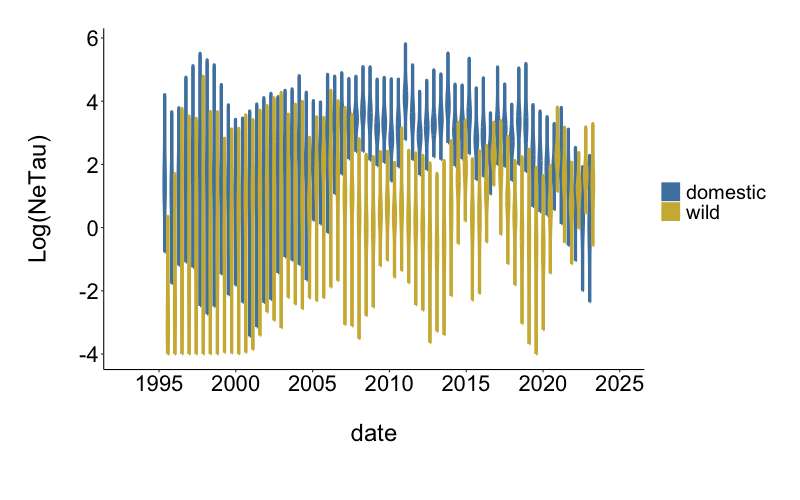

In [344]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_collapsed,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-violin-",label,"-",current_date,".pdf", sep="")

#Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_collapsed <- Ne_collapsed[!(Ne_collapsed$deme=="human"),]

p <- ggplot(data=Ne_collapsed) + 
    geom_violin(size=1.5, aes(x=date, y=Netau, group=interaction(interval,deme), color=deme, fill=deme))+
    #geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2025,5), limits=c(1993,2025))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

## Read in human case data

I have case data from all human infections with H5N1 from 2003 to 2020 from the [WHO](https://www.who.int/influenza/human_animal_interface/H5N1_cumulative_table_archives/en/)

In [345]:
"""this came from here: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years"""

from datetime import datetime as datetime
import time

def toYearFraction(date_string):
    if len(date_string) == 4:
        date = datetime.strptime(date_string, '%Y')
    elif len(date_string) == 7:
        date = datetime.strptime(date_string, '%Y-%m')
    else:
        date = datetime.strptime(date_string, '%Y-%m-%d')

    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [346]:
## make a dataframe with just year

human_cases = "human-case-data/h5n1-human-cases-1997-2024.csv"

human_cases_dict = {}

with open(human_cases, "r") as infile: 
    for line in infile: 
        if "# Note" not in line:
            if line.startswith("Range"): 
                number_columns = len(line.split(","))
            else: 
                year = line.split(",")[1].split("/")[-1]
                month = line.split(",")[1].split("/")[0]
                
                total_cases_in_row = 0
                for i in range(2,number_columns-1):
                    cases = int(line.split(",")[i])
                    total_cases_in_row += cases
                #print(total_cases_in_row)
            
                if year not in human_cases_dict:
                    human_cases_dict[year] = total_cases_in_row
                else: 
                    human_cases_dict[year] += total_cases_in_row

In [347]:
human_cases_df_year = pd.DataFrame(human_cases_dict, index=['cases']).transpose()
human_cases_df_year.reset_index(inplace=True)
human_cases_df_year.columns = ['year','cases']
human_cases_df_year

,year,cases
0,1997,18
1,1998,0
2,1999,0
3,2000,0
4,2001,0
5,2002,0
6,2003,6
7,2004,45
8,2005,100
9,2006,114


In [348]:
# and one by month
human_cases = "human-case-data/h5n1-human-cases-1997-2024.csv"

human_cases_df_year_month = pd.DataFrame()

with open(human_cases, "r") as infile: 
    for line in infile: 
        if "# Note" not in line:
            if line.startswith("Range"): 
                number_columns = len(line.split(","))
            else: 
                year = line.split(",")[1].split("/")[-1]
                month = line.split(",")[1].split("/")[0]
                if len(month) == 1: 
                    month = "0"+month
                
                decimal_date = toYearFraction(year + "-" +month+'-01')
                
                total_cases_in_row = 0
                for i in range(2,number_columns-1):
                    cases = int(line.split(",")[i])
                    total_cases_in_row += cases
                #print(total_cases_in_row)
            
                human_cases_dict = {"year": year, "month": month, 
                                        "cases": [total_cases_in_row], "decimal_date":decimal_date}
                df = pd.DataFrame.from_dict(human_cases_dict)
                
                human_cases_df_year_month = human_cases_df_year_month.append(df)

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2750440492.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  human_cases_df_year_month = human_cases_df_year_month.append(df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2750440492.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  human_cases_df_year_month = human_cases_df_year_month.append(df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2750440492.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  human_cases_df_year_month = human_cases_df_year_month.append(df)
/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_61449/2750440492.py:29: FutureWarning: The frame.append method is deprecated and will be rem

In [349]:
human_cases_df_year_month.head()

,year,month,cases,decimal_date
0,1997,01,0,1997.000000
0,1997,02,0,1997.084932
0,1997,03,0,1997.161644
0,1997,04,0,1997.246575
0,1997,05,1,1997.328653


In [350]:
mean = human_cases_df_year_month['cases'].mean()
std = human_cases_df_year_month['cases'].std()
human_cases_df_year_month['standardized_cases'] = (human_cases_df_year_month['cases'] - mean)/std
human_cases_df_year_month.head()

,year,month,cases,decimal_date,standardized_cases
0,1997,01,0,1997.000000,-0.469610
0,1997,02,0,1997.084932,-0.469610
0,1997,03,0,1997.161644,-0.469610
0,1997,04,0,1997.246575,-0.469610
0,1997,05,1,1997.328653,-0.303465


In [351]:
Ne_summary

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.000000,2023.139726
0,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.461160,2022.678566
0,domestic,3,0.917302,8.266128,1.696091,0.154208,49.669623,1.426292,0.922320,2022.217406
0,domestic,4,1.581236,38.127256,2.294904,0.906284,197.198872,8.059062,1.383480,2021.756246
0,domestic,5,2.046497,111.300570,2.865129,1.223238,733.042957,16.720068,1.844640,2021.295086
...,...,...,...,...,...,...,...,...,...,...
0,wild,57,-1.256434,0.055407,1.316202,-3.627596,20.711060,0.000236,25.824959,1997.314767
0,wild,58,-1.511844,0.030772,1.021793,-3.801425,10.514609,0.000158,26.286119,1996.853607
0,wild,59,-1.854631,0.013976,0.430016,-4.000000,2.691636,0.000100,26.747279,1996.392447
0,wild,60,-2.297508,0.005041,-0.446571,-4.000000,0.357626,0.000100,27.208439,1995.931287


In [352]:
mean = human_cases_df_year['cases'].mean()
std = human_cases_df_year['cases'].std()
human_cases_df_year['standardized_cases'] = (human_cases_df_year['cases'] - mean)/std
human_cases_df_year.head()

,year,cases,standardized_cases
0,1997,18,-0.373676
1,1998,0,-0.816620
2,1999,0,-0.816620
3,2000,0,-0.816620
4,2001,0,-0.816620


In [353]:
# standardize Ne for the summary dataframe
mean_Ne = Ne_summary['mean_Ne_log'].mean()
std_Ne = Ne_summary['mean_Ne_log'].std()
Ne_summary['standardized_log_Ne'] = (Ne_summary['mean_Ne_log'] - mean_Ne)/std_Ne
Ne_summary['standardized_lower_hpd_log'] = (Ne_summary['lower_hpd_log'] - Ne_summary['lower_hpd_log'].mean())/Ne_summary['lower_hpd_log'].std()
Ne_summary['standardized_upper_hpd_log'] = (Ne_summary['upper_hpd_log'] - Ne_summary['upper_hpd_log'].mean())/Ne_summary['upper_hpd_log'].std()

Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.00000,2023.139726,-0.756771,-0.560149,-1.023936
0,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.46116,2022.678566,-0.569376,-0.290917,-1.055060
0,domestic,3,0.917302,8.266128,1.696091,0.154208,49.669623,1.426292,0.92232,2022.217406,-0.129039,0.177890,-0.609990
0,domestic,4,1.581236,38.127256,2.294904,0.906284,197.198872,8.059062,1.38348,2021.756246,0.336239,0.583795,-0.058627
0,domestic,5,2.046497,111.300570,2.865129,1.223238,733.042957,16.720068,1.84464,2021.295086,0.662290,0.754859,0.466412


/Users/lhmoncla/miniconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In addition: Warning message:
In geom_line(data = Ne_summary, aes(x = date, y = mean_Ne_log, group = deme,  :
  Ignoring unknown aesthetics: fill


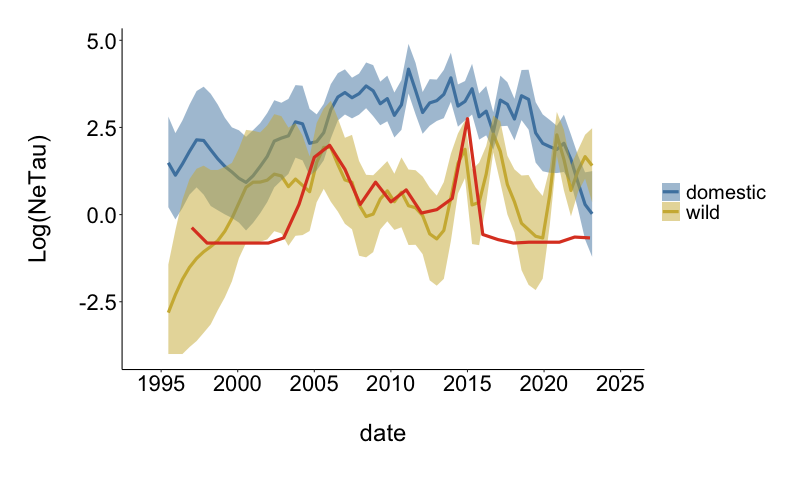

In [354]:
%%R -w 800 -h 500 -u px -i human_cases_df_year,current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-with-cases-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)
human_cases_df_year$year = as.numeric(human_cases_df_year$year)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p1 <- ggplot() + 
    geom_line(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme), size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    geom_line(data=human_cases_df_year, aes(x=year, y=standardized_cases), color=human_color, linetype=1, size=1.5)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1995,2025,5), limits=c(1994,2025))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

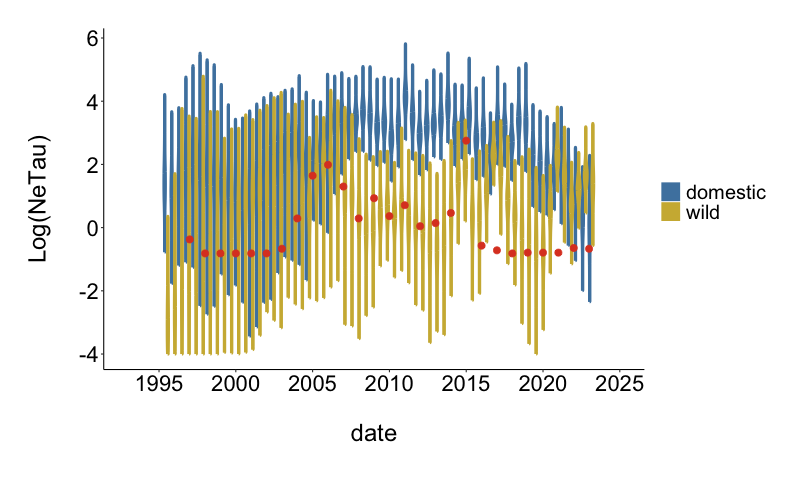

In [355]:
%%R -w 800 -h 500 -u px -i human_cases_df_year,current_date,label,Ne_collapsed,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-violin-with-cases-",label,"-",current_date,".pdf", sep="")

human_cases_df_year$year = as.numeric(human_cases_df_year$year)
#human_cases_df_year$decimal_date = as.numeric(human_cases_df$decimal_date)

# optionally, remove human 
Ne_collapsed <- Ne_collapsed[!(Ne_collapsed$deme=="human"),]

p <- ggplot(data=Ne_collapsed) + 
    geom_violin(size=1.5, aes(x=date, y=Netau, group=interaction(interval,deme), color=deme, fill=deme))+
    #geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    geom_point(data=human_cases_df_year, aes(x=year, y=standardized_cases), color=human_color, size=3)+    
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2025,5), limits=c(1993,2025))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

## Merging human and avian case count data with Ne estimates. 

Because our Ne's are computed across 10 intervals that don't necessarily line up to calendar years, we need a way to match human case count data with the appropriate Ne value. I decided to take the following approach, which I think is legitimate. 

For each interval we've estimated an Ne for, I compute the upper and lower bounds of 
that interval as (date of youngest tip - tree height)/10. This gives the number of years that each Ne interval represents. Then, we can assign these Nes to the human case count data. For example, if we  have human case counts for January 2021, then we can figure out which Ne interval that falls within and assign that Ne value to that case count number. I think that this is legitimate,  because coalescence rates within the entirety of that interval of time are used to infer Ne, so the Ne across that entire interval is meant to respresent that time period and is estimated from data across the interval. 

First, I will make a dictionary of intervals and test this out. Then, I will use the human case count data, look up the Ne interval it falls within, and combine those into a single dataframe.

REVISION: I don't think this is legit. I need to be doing the opposite, which is pooling the human case counts into the same intervals, and then comparing across those 11 Ne bins. 

In [356]:
"""
For each interval we've estimated an Ne for, I'd like to compute the upper and lower bounds of 
that interval. Generate a dictionary where the interval name is the key, and the the upper and lower bounds 
"""

Ne_intervals = set(Ne_summary["interval"].tolist())
Ne_intervals_dict = {}
for n in Ne_intervals:
    upper_bound = float(most_recent_tip) - ((float(n)*interval_size) - interval_size)
    lower_bound = float(most_recent_tip) - (((float(n)+1)*interval_size) - interval_size)
    
    # write these out to a dictionary
    Ne_intervals_dict[int(n)] = {"upper":upper_bound, "lower":lower_bound} #intervals are 1-indexed, so this second value is years from present

print(Ne_intervals_dict)

{44: {'upper': 2003.309846530594, 'lower': 2002.8486865422963}, 37: {'upper': 2006.5379664486784, 'lower': 2006.0768064603806}, 39: {'upper': 2005.6156464720827, 'lower': 2005.1544864837851}, 4: {'upper': 2021.756246062504, 'lower': 2021.2950860742062}, 19: {'upper': 2014.8388462380378, 'lower': 2014.37768624974}, 51: {'upper': 2000.0817266125098, 'lower': 1999.6205666242122}, 7: {'upper': 2020.3727660976108, 'lower': 2019.911606109313}, 60: {'upper': 1995.93128671783, 'lower': 1995.4701267295325}, 14: {'upper': 2017.1446461795265, 'lower': 2016.683486191229}, 49: {'upper': 2001.0040465891054, 'lower': 2000.5428866008076}, 22: {'upper': 2013.4553662731446, 'lower': 2012.9942062848468}, 41: {'upper': 2004.6933264954873, 'lower': 2004.2321665071895}, 8: {'upper': 2019.911606109313, 'lower': 2019.4504461210154}, 5: {'upper': 2021.2950860742062, 'lower': 2020.8339260859086}, 48: {'upper': 2001.465206577403, 'lower': 2001.0040465891054}, 3: {'upper': 2022.2174060508019, 'lower': 2021.756246

In [357]:
human_cases_df_year_month.head()

,year,month,cases,decimal_date,standardized_cases
0,1997,01,0,1997.000000,-0.469610
0,1997,02,0,1997.084932,-0.469610
0,1997,03,0,1997.161644,-0.469610
0,1997,04,0,1997.246575,-0.469610
0,1997,05,1,1997.328653,-0.303465


In [358]:
"""Now, pool human case counts into bins."""

human_cases_by_interval_df = pd.DataFrame()
human_cases_by_interval_dict = {}

all_dates = set(human_cases_df_year_month["decimal_date"].tolist())

for d in all_dates: 
    for i in range (1, len(Ne_intervals_dict)):
        if d <= Ne_intervals_dict[i]["upper"] and d > Ne_intervals_dict[i]["lower"]:
            # if the date falls within the upper and lower bounds of the Ne interval, pull out the cases 
            cases = human_cases_df_year_month.set_index("decimal_date").loc[d]["cases"]
            
            # then add to dictionary
            if str(i) in human_cases_by_interval_dict: 
                human_cases_by_interval_dict[str(i)] += int(cases)
            else: 
                human_cases_by_interval_dict[str(i)] = int(cases)
                
print(human_cases_by_interval_dict)
human_cases_by_interval_df = pd.DataFrame.from_dict(human_cases_by_interval_dict, orient="index").reset_index()
human_cases_by_interval_df.columns=["interval","human_cases"]
human_cases_by_interval_df

{'14': 2, '13': 1, '11': 0, '55': 17, '54': 0, '9': 1, '6': 1, '50': 0, '5': 0, '3': 1, '2': 2, '1': 7, '45': 0, '46': 0, '44': 2, '43': 0, '42': 35, '39': 45, '37': 73, '35': 54, '32': 5, '26': 33, '23': 2, '19': 13, '30': 25, '27': 26, '47': 0, '33': 35, '41': 8, '34': 32, '28': 12, '25': 16, '24': 29, '18': 162, '29': 33, '57': 0, '7': 0, '49': 0, '4': 1, '40': 27, '38': 57, '22': 24, '21': 15, '16': 5, '56': 1, '12': 1, '53': 0, '52': 0, '51': 0, '48': 0, '36': 18, '31': 45, '20': 16, '15': 6, '10': 0, '8': 0, '17': 5}


,interval,human_cases
0,14,2
1,13,1
2,11,0
3,55,17
4,54,0
5,9,1
6,6,1
7,50,0
8,5,0
9,3,1


In [359]:
sum(human_cases_df_year_month['cases'])

896

In [360]:
Ne_and_cases_df = Ne_summary.merge(human_cases_by_interval_df, on="interval")
Ne_and_cases_df.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,human_cases
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.00000,2023.139726,-0.756771,-0.560149,-1.023936,7
1,human,1,0.251980,1.786405,1.629348,-1.109975,42.593943,0.077629,0.00000,2023.139726,-0.595291,-0.504406,-0.671444,7
2,wild,1,1.405145,25.418200,2.479176,0.353001,301.422903,2.254246,0.00000,2023.139726,0.212836,0.285181,0.111043,7
3,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.46116,2022.678566,-0.569376,-0.290917,-1.055060,2
4,human,2,0.281692,1.912899,1.577288,-0.946214,37.782233,0.113184,0.46116,2022.678566,-0.574469,-0.416022,-0.719379,2


## Now add in avian reported case counts so that we look at those correlations as well

In [361]:
avian_cases_df = pd.read_csv("bird-outbreaks-data/epidemiology-data-cleaned-LHM-2023-10-13.tsv", sep="\t", index_col=False)
avian_cases_df.head()

,event_ID,HP_LP,subtype,region,continent,observation_date,reported_date,new_date,decimal_date,year,month,year_month_decimal_date,domestic_wild,host_species,host_group,dom_wild_host_group
0,364348,HPAI,H5N1,Asia,South-Eastern Asia,07/10/2023,09/10/2023,2023-10-07,2023.764269,2023.0,10.0,2023.747831,NaN,NaN,unknown,_unknown
1,364170,HPAI,H5N1,Europe,Eastern Europe,06/10/2023,09/10/2023,2023-10-06,2023.761530,2023.0,10.0,2023.747831,Domestic,unspecifiedbird,avian,domestic_or_captive_avian
2,364012,HPAI,H5N1,Europe,Southern Europe,05/10/2023,06/10/2023,2023-10-05,2023.758790,2023.0,10.0,2023.747831,Wild,muteswan,avian,wild_avian
3,364477,HPAI,H5,Asia,Eastern Asia,04/10/2023,11/10/2023,2023-10-04,2023.756050,2023.0,10.0,2023.747831,Wild,largebilledcrow,avian,wild_avian
4,364010,HPAI,H5N1,Americas,Northern America,02/10/2023,05/10/2023,2023-10-02,2023.750571,2023.0,10.0,2023.747831,Domestic,turkey,avian,domestic_or_captive_avian


In [362]:
# remove everything except for 3 groups: domestic or captive, wild, and mammal
print(len(avian_cases_df))
avian_cases_df = avian_cases_df[avian_cases_df['host_group']!= "unknown"]
avian_cases_df = avian_cases_df[avian_cases_df['host_group']!= "other"]
avian_cases_df = avian_cases_df[avian_cases_df['domestic_wild']!= "Environmental sample"]
avian_cases_df = avian_cases_df[avian_cases_df['domestic_wild']!= "Environmental Sample"]

print(len(avian_cases_df))

print(set(avian_cases_df['domestic_wild'].tolist()))
print(set(avian_cases_df['host_group'].tolist()))
print(set(avian_cases_df['dom_wild_host_group'].tolist()))

47810
46691
{'Domestic', 'Captive', 'Wild'}
{'nonhuman_mammal', 'avian'}
{'wild_avian', 'mammal', 'domestic_or_captive_avian'}


In [363]:
avian_cases_df.head()

,event_ID,HP_LP,subtype,region,continent,observation_date,reported_date,new_date,decimal_date,year,month,year_month_decimal_date,domestic_wild,host_species,host_group,dom_wild_host_group
1,364170,HPAI,H5N1,Europe,Eastern Europe,06/10/2023,09/10/2023,2023-10-06,2023.761530,2023.0,10.0,2023.747831,Domestic,unspecifiedbird,avian,domestic_or_captive_avian
2,364012,HPAI,H5N1,Europe,Southern Europe,05/10/2023,06/10/2023,2023-10-05,2023.758790,2023.0,10.0,2023.747831,Wild,muteswan,avian,wild_avian
3,364477,HPAI,H5,Asia,Eastern Asia,04/10/2023,11/10/2023,2023-10-04,2023.756050,2023.0,10.0,2023.747831,Wild,largebilledcrow,avian,wild_avian
4,364010,HPAI,H5N1,Americas,Northern America,02/10/2023,05/10/2023,2023-10-02,2023.750571,2023.0,10.0,2023.747831,Domestic,turkey,avian,domestic_or_captive_avian
5,363836,HPAI,H5N1,Americas,South America,01/10/2023,05/10/2023,2023-10-01,2023.747831,2023.0,10.0,2023.747831,Wild,southamericansealion,avian,wild_avian


In [364]:
"""
Now, compute monthly case counts per host group.
"""

avian_cases_df2 = pd.DataFrame()

for host_group in ["domestic_or_captive_avian","wild_avian"]: 
    local_df = avian_cases_df[avian_cases_df['dom_wild_host_group'] == host_group]
    
    all_dates = set(local_df["year_month_decimal_date"].tolist())
    for d in all_dates: 
        local_df2 = local_df[local_df['year_month_decimal_date'] == d]
        x = pd.DataFrame.from_dict({"decimal_date":d, "host_group":[host_group], "cases":len(local_df2)})
        avian_cases_df2 = pd.concat([avian_cases_df2,x])

In [365]:
print(len(avian_cases_df2))
avian_cases_df2.head()

405


,decimal_date,host_group,cases
0,2015.328653,domestic_or_captive_avian,140
0,2015.246461,domestic_or_captive_avian,257
0,2015.161644,domestic_or_captive_avian,276
0,2015.084932,domestic_or_captive_avian,581
0,2015.000000,domestic_or_captive_avian,720


In [366]:
"""
Now, compute the proportion of monthly case counts per host group.
"""

df2 = pd.DataFrame()

all_dates = set(avian_cases_df["year_month_decimal_date"].tolist())
for d in all_dates: 
    local_df = avian_cases_df[avian_cases_df['year_month_decimal_date'] == d]
    total_reports = len(local_df)
    
    number_wild = len(local_df[local_df['dom_wild_host_group'] == 'wild_avian'])
    number_dom = len(local_df[local_df['dom_wild_host_group'] == 'domestic_or_captive_avian'])
    number_mammal = len(local_df[local_df['dom_wild_host_group'] == 'mammal'])
 
    if number_wild != 0:
        prop_wild = number_wild/total_reports
    else: 
        prop_wild = 0
    if number_dom != 0:
        prop_dom = number_dom/total_reports
    else: 
        prop_dom = 0
    if number_mammal != 0:
        prop_mammal = number_mammal/total_reports
    else: 
        prop_mammal = 0
    
    
    x = pd.DataFrame({"decimal_date":d, "domestic_or_captive_avian":[prop_dom], "wild_avian":prop_wild})
    df2 = pd.concat([df2,x])

In [367]:
df3 = pd.melt(df2, id_vars=['decimal_date'], value_vars=['domestic_or_captive_avian','wild_avian'])
df3.columns = ["decimal_date","host_group","proportion_cases"]
print(len(df3))
df3.head()

482


,decimal_date,host_group,proportion_cases
0,2015.328653,domestic_or_captive_avian,0.903226
1,2015.246461,domestic_or_captive_avian,0.973485
2,2015.161644,domestic_or_captive_avian,0.961672
3,2015.084932,domestic_or_captive_avian,0.981419
4,2015.000000,domestic_or_captive_avian,0.953642


In [368]:
"""combine these into a single dataframe"""
avian_cases_df3 = avian_cases_df2.merge(df3, on=["decimal_date","host_group"], how="outer")
print(len(avian_cases_df3))
avian_cases_df3["cases"] = avian_cases_df3["cases"].fillna(0)
avian_cases_df3

482


,decimal_date,host_group,cases,proportion_cases
0,2015.328653,domestic_or_captive_avian,140.0,0.903226
1,2015.246461,domestic_or_captive_avian,257.0,0.973485
2,2015.161644,domestic_or_captive_avian,276.0,0.961672
3,2015.084932,domestic_or_captive_avian,581.0,0.981419
4,2015.000000,domestic_or_captive_avian,720.0,0.953642
...,...,...,...,...
477,2020.330487,wild_avian,0.0,0.000000
478,2020.248520,wild_avian,0.0,0.000000
479,2014.413584,wild_avian,0.0,0.000000
480,2014.328653,wild_avian,0.0,0.000000


In [369]:
"""Now, pool these case counts into bins."""

for host in ['wild_avian','domestic_or_captive_avian']:
    
    host_cases_by_interval_df = pd.DataFrame()
    host_cases_by_interval_dict = {}

    host_df = avian_cases_df3[avian_cases_df3['host_group'] == host]
    all_dates = set(host_df["decimal_date"].tolist())

    for d in all_dates: 
        for i in range (1, len(Ne_intervals_dict)):
            if d <= Ne_intervals_dict[i]["upper"] and d > Ne_intervals_dict[i]["lower"]:
                # if the date falls within the upper and lower bounds of the Ne interval, pull out the cases 
                cases = host_df.set_index("decimal_date").loc[d]["cases"]

                # then add to dictionary
                if str(i) in host_cases_by_interval_dict: 
                    host_cases_by_interval_dict[str(i)] += int(cases)
                else: 
                    host_cases_by_interval_dict[str(i)] = int(cases)
                
    print(host_cases_by_interval_dict)
    host_cases_by_interval_df = pd.DataFrame.from_dict(host_cases_by_interval_dict, orient="index").reset_index()
    cases_column_name = host + "_cases"
    host_cases_by_interval_df.columns=["interval",cases_column_name]
    
    
    Ne_and_cases_df= Ne_and_cases_df.merge(host_cases_by_interval_df, on="interval", how="outer")

Ne_and_cases_df.head()

{'16': 8, '17': 23, '23': 2, '14': 1285, '15': 10, '20': 22, '22': 5, '13': 109, '12': 109, '25': 14, '10': 17, '7': 25, '9': 17, '8': 2, '6': 593, '4': 288, '5': 1017, '19': 10, '21': 1, '34': 37, '28': 13, '30': 32, '1': 1249, '3': 2479, '2': 1113, '29': 5, '40': 1, '41': 2, '24': 15, '39': 103, '36': 5, '26': 7, '35': 52, '32': 3, '31': 6, '42': 4, '38': 85, '37': 608, '33': 32, '27': 66, '18': 84, '11': 117}
{'17': 596, '16': 735, '14': 1915, '15': 420, '20': 509, '22': 440, '13': 840, '12': 317, '25': 327, '10': 114, '11': 330, '8': 66, '7': 474, '6': 231, '4': 484, '5': 1563, '19': 438, '30': 937, '2': 1464, '1': 1506, '3': 1987, '21': 216, '29': 1536, '23': 160, '41': 791, '38': 745, '39': 164, '36': 155, '31': 822, '35': 693, '34': 260, '18': 2277, '27': 1138, '33': 546, '32': 110, '42': 2600, '40': 2657, '37': 1552, '28': 658, '26': 1191, '24': 429, '9': 132}


,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,human_cases,wild_avian_cases,domestic_or_captive_avian_cases
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.00000,2023.139726,-0.756771,-0.560149,-1.023936,7,1249.0,1506.0
1,human,1,0.251980,1.786405,1.629348,-1.109975,42.593943,0.077629,0.00000,2023.139726,-0.595291,-0.504406,-0.671444,7,1249.0,1506.0
2,wild,1,1.405145,25.418200,2.479176,0.353001,301.422903,2.254246,0.00000,2023.139726,0.212836,0.285181,0.111043,7,1249.0,1506.0
3,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.46116,2022.678566,-0.569376,-0.290917,-1.055060,2,1113.0,1464.0
4,human,2,0.281692,1.912899,1.577288,-0.946214,37.782233,0.113184,0.46116,2022.678566,-0.574469,-0.416022,-0.719379,2,1113.0,1464.0


In [370]:
Ne_and_cases_df[Ne_and_cases_df['deme'] == "domestic"]

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,human_cases,wild_avian_cases,domestic_or_captive_avian_cases
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.000000,2023.139726,-0.756771,-0.560149,-1.023936,7,1249.0,1506.0
3,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.461160,2022.678566,-0.569376,-0.290917,-1.055060,2,1113.0,1464.0
6,domestic,3,0.917302,8.266128,1.696091,0.154208,49.669623,1.426292,0.922320,2022.217406,-0.129039,0.177890,-0.609990,1,2479.0,1987.0
9,domestic,4,1.581236,38.127256,2.294904,0.906284,197.198872,8.059062,1.383480,2021.756246,0.336239,0.583795,-0.058627,1,288.0,484.0
12,domestic,5,2.046497,111.300570,2.865129,1.223238,733.042957,16.720068,1.844640,2021.295086,0.662290,0.754859,0.466412,0,1017.0,1563.0
15,domestic,6,1.869089,73.975689,2.548960,1.191784,353.965020,15.551917,2.305800,2020.833926,0.537964,0.737883,0.175297,1,593.0,231.0
18,domestic,7,1.948965,88.912984,2.716253,1.199108,520.299395,15.816411,2.766960,2020.372766,0.593940,0.741836,0.329333,0,25.0,474.0
21,domestic,8,2.044028,110.669522,2.874738,1.243095,749.441583,17.502302,3.228120,2019.911606,0.660560,0.765577,0.475259,0,2.0,66.0
24,domestic,9,2.343741,220.668973,3.227712,1.491144,1689.320321,30.984495,3.689280,2019.450446,0.870596,0.899452,0.800263,1,17.0,132.0
27,domestic,10,3.305621,2021.255781,4.156184,2.437275,14327.949169,273.699899,4.150440,2018.989286,1.544672,1.410091,1.655161,0,17.0,114.0



Call:
lm(formula = domestic_or_captive_avian_cases ~ mean_Ne_log, data = Ne_and_cases_df)

Residuals:
   Min     1Q Median     3Q    Max 
-899.8 -503.6 -198.6  204.2 1742.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1360.3      348.0   3.909 0.000349 ***
mean_Ne_log   -193.0      118.8  -1.624 0.112165    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 688.2 on 40 degrees of freedom
  (15 observations deleted due to missingness)
Multiple R-squared:  0.06188,	Adjusted R-squared:  0.03842 
F-statistic: 2.638 on 1 and 40 DF,  p-value: 0.1122

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 15 rows containing non-finite values (`stat_smooth()`). 

R[write to console]: 2: Removed 15 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 15 rows containing non-finite values (`stat_smooth()`). 
2: Removed 15 rows containing missing values (`geom_point()`). 


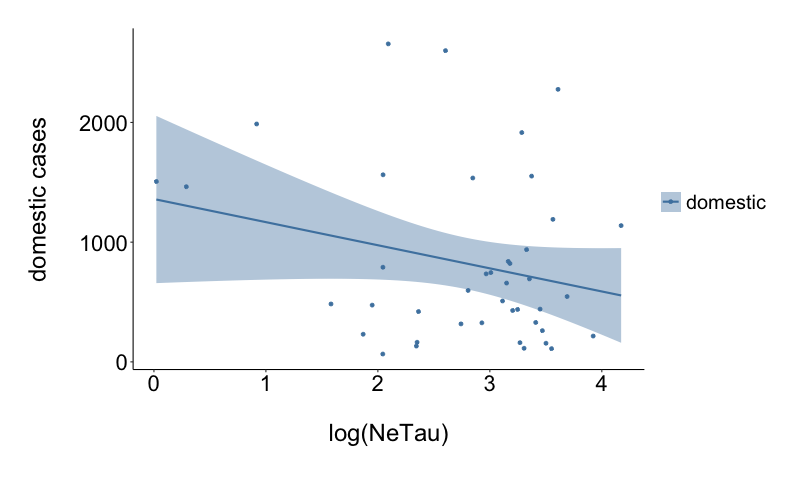

In [371]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_df,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("domestic-NeTau-log-vs-domestic_cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_df$interval = as.numeric(Ne_and_cases_df$interval)
Ne_and_cases_df$year = as.numeric(Ne_and_cases_df$year)

# optionally, just do domestic 
Ne_and_cases_df <- Ne_and_cases_df[(Ne_and_cases_df$deme=="domestic"),]

reg1 <- lm(domestic_or_captive_avian_cases~mean_Ne_log,data=Ne_and_cases_df) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_df, aes(x=mean_Ne_log, y=domestic_or_captive_avian_cases,group=deme, color=deme, fill=deme)) + 
    geom_jitter(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="domestic cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     #scale_y_continuous(breaks=seq(0,30,5), limits=c(0,20))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = wild_avian_cases ~ mean_Ne_log, data = Ne_and_cases_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-603.21 -212.29  -76.32   80.06 2117.81 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)    60.97      94.18   0.647  0.52105   
mean_Ne_log   239.19      86.30   2.772  0.00843 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 464.4 on 40 degrees of freedom
  (15 observations deleted due to missingness)
Multiple R-squared:  0.1611,	Adjusted R-squared:  0.1401 
F-statistic: 7.681 on 1 and 40 DF,  p-value: 0.008427

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 15 rows containing non-finite values (`stat_smooth()`). 

R[write to console]: 2: Removed 15 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 15 rows containing non-finite values (`stat_smooth()`). 
2: Removed 15 rows containing missing values (`geom_point()`). 


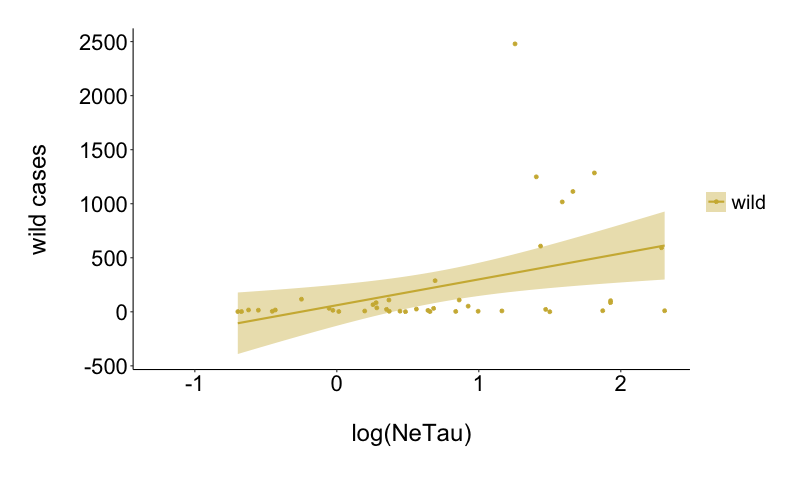

In [372]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_df,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("wild-NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_df$interval = as.numeric(Ne_and_cases_df$interval)
Ne_and_cases_df$year = as.numeric(Ne_and_cases_df$year)

# optionally, just do domestic 
Ne_and_cases_df <- Ne_and_cases_df[(Ne_and_cases_df$deme=="wild"),]

reg1 <- lm(wild_avian_cases~mean_Ne_log,data=Ne_and_cases_df) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_df, aes(x=mean_Ne_log, y=wild_avian_cases,group=deme, color=deme, fill=deme)) + 
    geom_jitter(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="wild cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     #scale_y_continuous(breaks=seq(0,30,5), limits=c(0,20))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

In [373]:
Ne_and_cases_df.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,human_cases,wild_avian_cases,domestic_or_captive_avian_cases
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.00000,2023.139726,-0.756771,-0.560149,-1.023936,7,1249.0,1506.0
1,human,1,0.251980,1.786405,1.629348,-1.109975,42.593943,0.077629,0.00000,2023.139726,-0.595291,-0.504406,-0.671444,7,1249.0,1506.0
2,wild,1,1.405145,25.418200,2.479176,0.353001,301.422903,2.254246,0.00000,2023.139726,0.212836,0.285181,0.111043,7,1249.0,1506.0
3,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.46116,2022.678566,-0.569376,-0.290917,-1.055060,2,1113.0,1464.0
4,human,2,0.281692,1.912899,1.577288,-0.946214,37.782233,0.113184,0.46116,2022.678566,-0.574469,-0.416022,-0.719379,2,1113.0,1464.0


In [374]:
"""compute proportion cases per host vs. interval Ne"""

props_df = pd.DataFrame()
all_intervals = set(Ne_and_cases_df["interval"].tolist())

for i in all_intervals: 
    local_df = Ne_and_cases_df[Ne_and_cases_df['interval']==i]
        
    dom_cases = local_df.set_index("deme").loc['domestic']["domestic_or_captive_avian_cases"]
    wild_cases = local_df.set_index("deme").loc['domestic']["wild_avian_cases"]
    total_avian_cases = dom_cases + wild_cases
    
    if dom_cases != 0:
        prop_dom = dom_cases/total_avian_cases
    else:
        prop_dom = 0
    
    if wild_cases != 0:
        prop_wild = wild_cases/total_avian_cases
    else:
        prop_wild = 0
        
        
    x = pd.DataFrame({"interval":i, "prop_dom":[prop_dom], "prop_wild":prop_wild})
    
    props_df = pd.concat([props_df, x])
props_df

,interval,prop_dom,prop_wild
0,44,NaN,NaN
0,37,0.718519,0.281481
0,39,0.614232,0.385768
0,4,0.626943,0.373057
0,19,0.977679,0.022321
0,51,NaN,NaN
0,7,0.949900,0.050100
0,14,0.598437,0.401562
0,49,NaN,NaN
0,22,0.988764,0.011236


In [375]:
Ne_and_props_df = Ne_and_cases_df.merge(props_df, on="interval", how="outer")
Ne_and_props_df

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,human_cases,wild_avian_cases,domestic_or_captive_avian_cases,prop_dom,prop_wild
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.000000,2023.139726,-0.756771,-0.560149,-1.023936,7,1249.0,1506.0,0.546642,0.453358
1,human,1,0.251980,1.786405,1.629348,-1.109975,42.593943,0.077629,0.000000,2023.139726,-0.595291,-0.504406,-0.671444,7,1249.0,1506.0,0.546642,0.453358
2,wild,1,1.405145,25.418200,2.479176,0.353001,301.422903,2.254246,0.000000,2023.139726,0.212836,0.285181,0.111043,7,1249.0,1506.0,0.546642,0.453358
3,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.461160,2022.678566,-0.569376,-0.290917,-1.055060,2,1113.0,1464.0,0.568102,0.431898
4,human,2,0.281692,1.912899,1.577288,-0.946214,37.782233,0.113184,0.461160,2022.678566,-0.574469,-0.416022,-0.719379,2,1113.0,1464.0,0.568102,0.431898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,human,56,-1.449525,0.035520,0.941916,-3.778479,8.748148,0.000167,25.363799,1997.775927,-1.787690,-1.944633,-1.304402,1,NaN,NaN,NaN,NaN
167,wild,56,-1.066647,0.085773,1.404144,-3.391913,25.359705,0.000406,25.363799,1997.775927,-1.519373,-1.735998,-0.878802,1,NaN,NaN,NaN,NaN
168,domestic,57,2.144544,139.490311,3.544520,0.781048,3503.642493,6.040156,25.824959,1997.314767,0.731000,0.516204,1.091966,0,NaN,NaN,NaN,NaN
169,human,57,-1.500033,0.031620,0.889017,-3.756508,7.744915,0.000175,25.824959,1997.314767,-1.823085,-1.932775,-1.353110,0,NaN,NaN,NaN,NaN


In [376]:
Ne_and_props_df[Ne_and_props_df['deme']=='domestic']

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,human_cases,wild_avian_cases,domestic_or_captive_avian_cases,prop_dom,prop_wild
0,domestic,1,0.021554,1.050882,1.246520,-1.213257,17.640865,0.061199,0.000000,2023.139726,-0.756771,-0.560149,-1.023936,7,1249.0,1506.0,0.546642,0.453358
3,domestic,2,0.288960,1.945181,1.212716,-0.714414,16.319860,0.193013,0.461160,2022.678566,-0.569376,-0.290917,-1.055060,2,1113.0,1464.0,0.568102,0.431898
6,domestic,3,0.917302,8.266128,1.696091,0.154208,49.669623,1.426292,0.922320,2022.217406,-0.129039,0.177890,-0.609990,1,2479.0,1987.0,0.444917,0.555083
9,domestic,4,1.581236,38.127256,2.294904,0.906284,197.198872,8.059062,1.383480,2021.756246,0.336239,0.583795,-0.058627,1,288.0,484.0,0.626943,0.373057
12,domestic,5,2.046497,111.300570,2.865129,1.223238,733.042957,16.720068,1.844640,2021.295086,0.662290,0.754859,0.466412,0,1017.0,1563.0,0.605814,0.394186
15,domestic,6,1.869089,73.975689,2.548960,1.191784,353.965020,15.551917,2.305800,2020.833926,0.537964,0.737883,0.175297,1,593.0,231.0,0.280340,0.719660
18,domestic,7,1.948965,88.912984,2.716253,1.199108,520.299395,15.816411,2.766960,2020.372766,0.593940,0.741836,0.329333,0,25.0,474.0,0.949900,0.050100
21,domestic,8,2.044028,110.669522,2.874738,1.243095,749.441583,17.502302,3.228120,2019.911606,0.660560,0.765577,0.475259,0,2.0,66.0,0.970588,0.029412
24,domestic,9,2.343741,220.668973,3.227712,1.491144,1689.320321,30.984495,3.689280,2019.450446,0.870596,0.899452,0.800263,1,17.0,132.0,0.885906,0.114094
27,domestic,10,3.305621,2021.255781,4.156184,2.437275,14327.949169,273.699899,4.150440,2018.989286,1.544672,1.410091,1.655161,0,17.0,114.0,0.870229,0.129771



Call:
lm(formula = prop_dom ~ mean_Ne_log, data = Ne_and_props_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47253 -0.06506  0.02017  0.07866  0.22360 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.52951    0.07420   7.136 1.21e-08 ***
mean_Ne_log  0.11951    0.02534   4.716 2.91e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1467 on 40 degrees of freedom
  (15 observations deleted due to missingness)
Multiple R-squared:  0.3574,	Adjusted R-squared:  0.3413 
F-statistic: 22.24 on 1 and 40 DF,  p-value: 2.91e-05

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 15 rows containing non-finite values (`stat_smooth()`). 

R[write to console]: 2: Removed 15 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 15 rows containing non-finite values (`stat_smooth()`). 
2: Removed 15 rows containing missing values (`geom_point()`). 


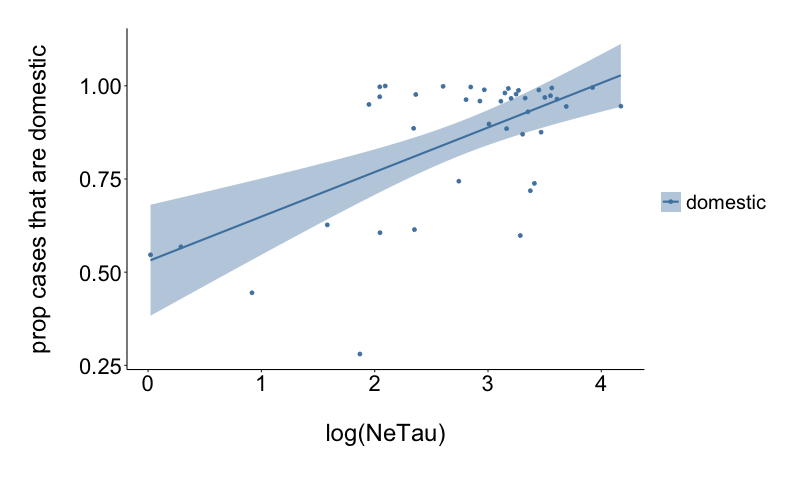

In [377]:
%%R -w 800 -h 500 -u px -i Ne_and_props_df,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("domestic-NeTau-log-vs-prop-domestic_cases-",label,"-",current_date,".pdf", sep="")

Ne_and_props_df$interval = as.numeric(Ne_and_props_df$interval)

# optionally, just do domestic 
Ne_and_props_df <- Ne_and_props_df[(Ne_and_props_df$deme=="domestic"),]

reg1 <- lm(prop_dom~mean_Ne_log,data=Ne_and_props_df) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_props_df, aes(x=mean_Ne_log, y=prop_dom,group=deme, color=deme, fill=deme)) + 
    geom_jitter(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="prop cases that are domestic\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     #scale_y_continuous(breaks=seq(0,30,5), limits=c(0,20))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = prop_wild ~ mean_Ne_log, data = Ne_and_props_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27591 -0.10825 -0.03721  0.11059  0.42273 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.06558    0.03276   2.001  0.05217 . 
mean_Ne_log  0.10117    0.03003   3.370  0.00168 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1616 on 40 degrees of freedom
  (15 observations deleted due to missingness)
Multiple R-squared:  0.2211,	Adjusted R-squared:  0.2016 
F-statistic: 11.35 on 1 and 40 DF,  p-value: 0.001677

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 15 rows containing non-finite values (`stat_smooth()`). 

R[write to console]: 2: Removed 15 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 15 rows containing non-finite values (`stat_smooth()`). 
2: Removed 15 rows containing missing values (`geom_point()`). 


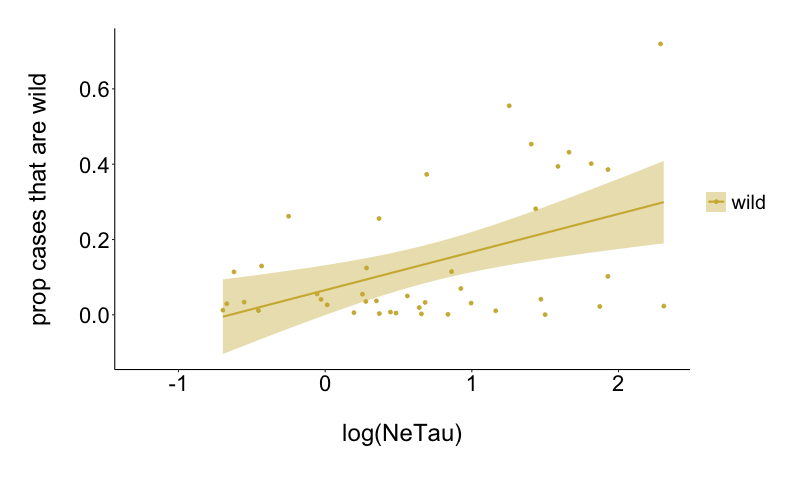

In [378]:
%%R -w 800 -h 500 -u px -i Ne_and_props_df,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("wild-NeTau-log-vs-prop-domestic_cases-",label,"-",current_date,".pdf", sep="")

Ne_and_props_df$interval = as.numeric(Ne_and_props_df$interval)

# optionally, just do domestic 
Ne_and_props_df <- Ne_and_props_df[(Ne_and_props_df$deme=="wild"),]

reg1 <- lm(prop_wild~mean_Ne_log,data=Ne_and_props_df) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_props_df, aes(x=mean_Ne_log, y=prop_wild,group=deme, color=deme, fill=deme)) + 
    geom_jitter(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="prop cases that are wild\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     #scale_y_continuous(breaks=seq(0,30,5), limits=c(0,20))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = human_cases ~ mean_Ne_log, data = Ne_and_cases_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.510 -11.385  -4.804   4.782 133.099 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -14.373      9.048  -1.589 0.117906    
mean_Ne_log   11.990      3.382   3.545 0.000809 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.97 on 55 degrees of freedom
Multiple R-squared:  0.186,	Adjusted R-squared:  0.1712 
F-statistic: 12.57 on 1 and 55 DF,  p-value: 0.0008094

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


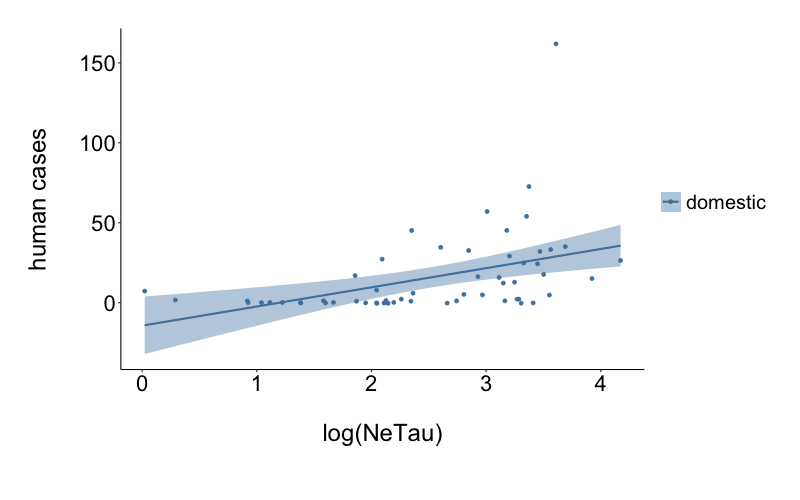

In [379]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_df,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("domestic-NeTau-log-vs-human-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_df$interval = as.numeric(Ne_and_cases_df$interval)
Ne_and_cases_df$year = as.numeric(Ne_and_cases_df$year)

# optionally, just do domestic 
Ne_and_cases_df <- Ne_and_cases_df[(Ne_and_cases_df$deme=="domestic"),]

reg1 <- lm(human_cases~mean_Ne_log,data=Ne_and_cases_df) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_df, aes(x=mean_Ne_log, y=human_cases,group=deme, color=deme, fill=deme)) + 
    geom_jitter(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     #scale_y_continuous(breaks=seq(0,30,5), limits=c(0,20))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = human_cases ~ mean_Ne_log, data = Ne_and_cases_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.662 -15.095 -10.798   9.183 147.051 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   14.299      4.229   3.381  0.00134 **
mean_Ne_log    2.345      4.053   0.579  0.56521   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.48 on 55 degrees of freedom
Multiple R-squared:  0.00605,	Adjusted R-squared:  -0.01202 
F-statistic: 0.3348 on 1 and 55 DF,  p-value: 0.5652

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


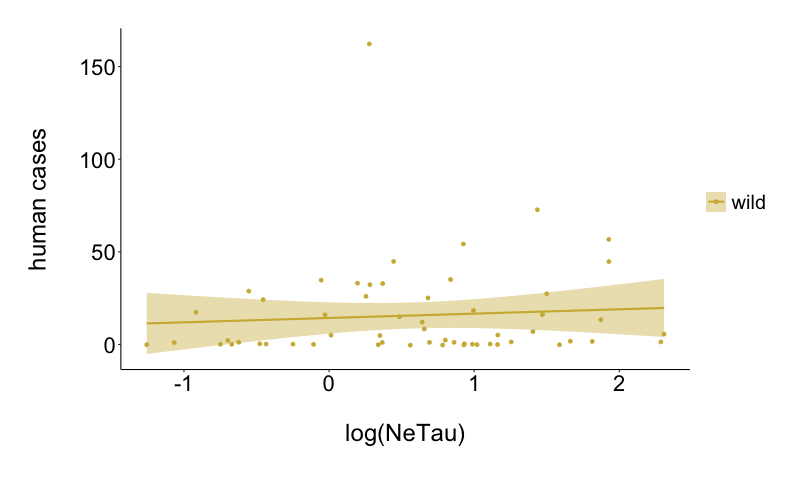

In [380]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_df,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("wild-NeTau-log-vs-human-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_df$interval = as.numeric(Ne_and_cases_df$interval)
Ne_and_cases_df$year = as.numeric(Ne_and_cases_df$year)

# optionally, just do domestic 
Ne_and_cases_df <- Ne_and_cases_df[(Ne_and_cases_df$deme=="wild"),]

reg1 <- lm(human_cases~mean_Ne_log,data=Ne_and_cases_df) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_df, aes(x=mean_Ne_log, y=human_cases,group=deme, color=deme, fill=deme)) + 
    geom_jitter(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     #scale_y_continuous(breaks=seq(0,30,5), limits=c(0,20))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

## old code I don't use any more

In [55]:
Ne_and_cases_collapsed.head()

,sample,Netau,deme,interval,years_from_present,date,year,cases,standardized_cases
0,0,-1.837607,domestic,1,0.0,2023.1397,2023,6.0,-0.668972
1,50000,-1.900772,domestic,1,0.0,2023.1397,2023,6.0,-0.668972
2,100000,-0.926464,domestic,1,0.0,2023.1397,2023,6.0,-0.668972
3,150000,-0.688015,domestic,1,0.0,2023.1397,2023,6.0,-0.668972
4,200000,-0.809262,domestic,1,0.0,2023.1397,2023,6.0,-0.668972



Call:
lm(formula = cases ~ Netau, data = Ne_and_cases_collapsed)

Residuals:
    Min      1Q  Median      3Q     Max 
-79.026 -31.327  -6.853   7.967 140.042 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  18.0412     0.2513   71.79   <2e-16 ***
Netau        13.6005     0.1112  122.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43.03 on 51753 degrees of freedom
  (17 observations deleted due to missingness)
Multiple R-squared:  0.2242,	Adjusted R-squared:  0.2241 
F-statistic: 1.495e+04 on 1 and 51753 DF,  p-value: < 2.2e-16



R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 17 rows containing missing values (`geom_point()`). 



In addition: Warning message:
Removed 17 rows containing missing values (`geom_point()`). 


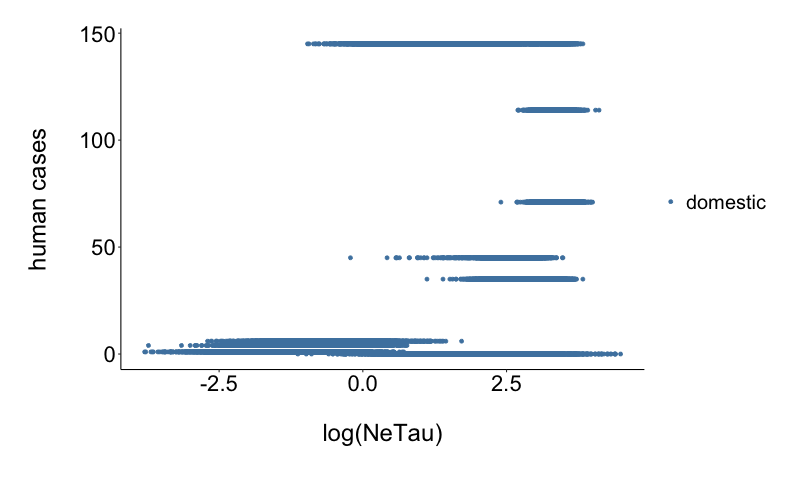

In [56]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_collapsed,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("domestic-NeTau-log-vs-cases-posterior-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_collapsed$interval = as.numeric(Ne_and_cases_collapsed$interval)
Ne_and_cases_collapsed$year = as.numeric(Ne_and_cases_collapsed$year)

# optionally, just do domestic 
Ne_and_cases_collapsed <- Ne_and_cases_collapsed[(Ne_and_cases_collapsed$deme=="domestic"),]

reg1 <- lm(cases~Netau,data=Ne_and_cases_collapsed) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_collapsed, aes(x=Netau, y=cases, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    #geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = cases ~ Netau, data = Ne_and_cases_collapsed)

Residuals:
   Min     1Q Median     3Q    Max 
-58.16 -42.16 -15.20  30.85 109.13 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  29.8657     0.2435  122.65   <2e-16 ***
Netau         7.3690     0.1132   65.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 46.97 on 51753 degrees of freedom
  (17 observations deleted due to missingness)
Multiple R-squared:  0.07573,	Adjusted R-squared:  0.07571 
F-statistic:  4240 on 1 and 51753 DF,  p-value: < 2.2e-16



R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 17 rows containing missing values (`geom_point()`). 



In addition: Warning message:
Removed 17 rows containing missing values (`geom_point()`). 


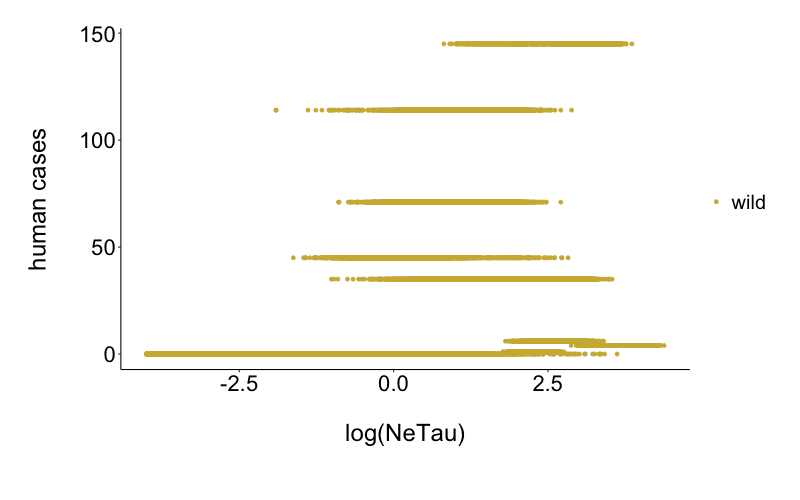

In [57]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_collapsed,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("wild-NeTau-log-vs-cases-posterior-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_collapsed$interval = as.numeric(Ne_and_cases_collapsed$interval)
Ne_and_cases_collapsed$year = as.numeric(Ne_and_cases_collapsed$year)

# optionally, just do domestic 
Ne_and_cases_collapsed <- Ne_and_cases_collapsed[(Ne_and_cases_collapsed$deme=="wild"),]

reg1 <- lm(cases~Netau,data=Ne_and_cases_collapsed) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_collapsed, aes(x=Netau, y=cases, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    #geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

In [58]:
# calculate a correlation coefficient
import scipy.stats

# human
human_Ne_df = Ne_and_cases_summary[Ne_and_cases_summary['deme'] == "human"]
human_Ne = human_Ne_df['mean_Ne_log']
human_cases_h = human_Ne_df['standardized_cases']

# domestic first 
domestic_Ne_df = Ne_and_cases_summary[Ne_and_cases_summary['deme'] == "domestic"]
domestic_Ne = domestic_Ne_df['mean_Ne_log']
human_cases_d = domestic_Ne_df['standardized_cases']

# wild
wild_Ne_df = Ne_and_cases_summary[Ne_and_cases_summary['deme'] == "wild"]
wild_Ne = wild_Ne_df['mean_Ne_log']
human_cases_w = wild_Ne_df['standardized_cases']

# this prints the correlation and the p-value
scipy.stats.pearsonr(domestic_Ne, human_cases_d)

(0.5235460046180447, 0.09836626812810051)

In [59]:
# correlation, p-value
scipy.stats.pearsonr(wild_Ne, human_cases_w)

(0.1803283003427541, 0.5957019535572039)

In [60]:
# correlation, p-value
scipy.stats.pearsonr(human_Ne, human_cases_w)

(-0.026980235492585308, 0.9372376780729442)

In [61]:
# wild vs. domestic 
scipy.stats.pearsonr(domestic_Ne, wild_Ne)

(-0.4570889373060127, 0.15752464874956187)

In [62]:
# correlation, p-value
scipy.stats.pearsonr(domestic_Ne, human_cases_d)

(0.5235460046180447, 0.09836626812810051)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 2 rows containing missing values (`geom_line()`). 



In addition: Warning message:
Removed 2 rows containing missing values (`geom_line()`). 


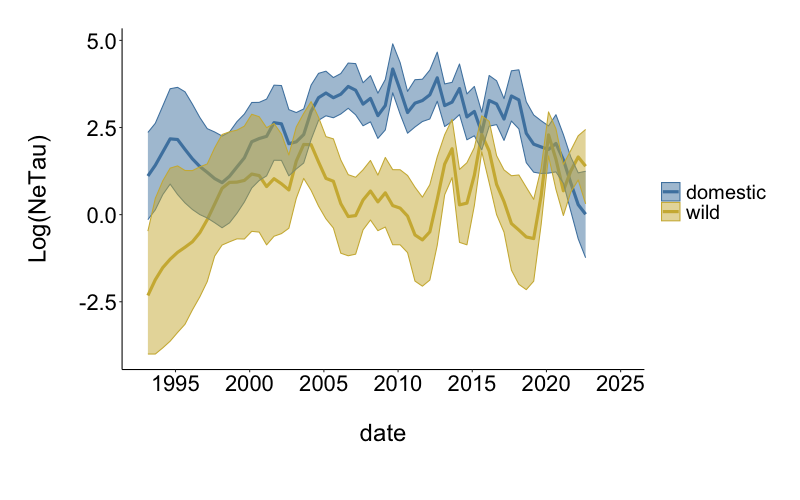

In [62]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2025,5), limits=c(1993,2025))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

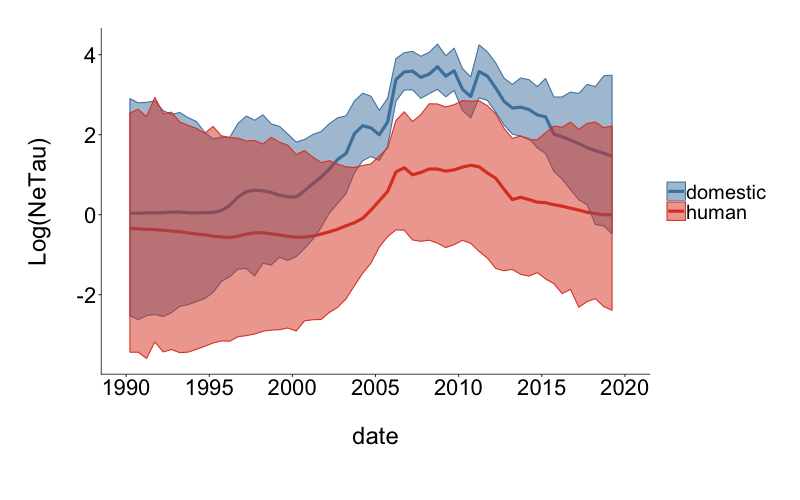

In [70]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-2-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove wild
Ne_summary <- Ne_summary[!(Ne_summary$deme=="wild"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

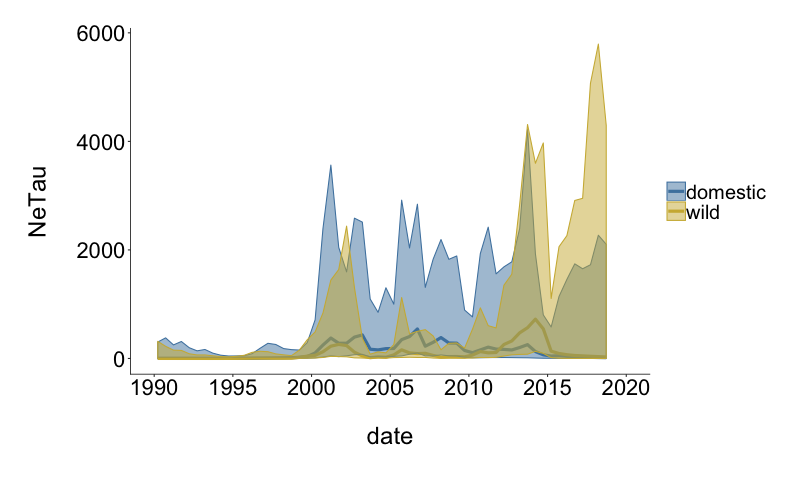

In [176]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-linear-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_linear,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_linear, ymax = upper_hpd_linear,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="NeTau\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [47]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [140]:
all_trees = "beast-runs/2021-02-16-mascot-3deme/test.trees"
burnin_percent = 0.0

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

0.0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [157]:
def return_persistence_times(tree, return_dict):
            
    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k
        
        if 'max' in k.traits:
            host = k.traits['max']
        else:
            host = 'ancestor'
        
        if k.branchType == "node":
            children = k.children
            
            ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            traverse_condition=lambda w:w.traits['max'].lower().replace()==kloc
            subtree=tree.subtree(k,traverse_condition=traverse_condition) 


In [158]:
hosts_dict = {'human':[],'domestic':[],'wild':[]}
return_persistence_times(tree, hosts_dict)

[<baltic.node object at 0x7fb1c3d19f28>, <baltic.node object at 0x7fb1c6c065f8>]
[<baltic.node object at 0x7fb1c3d19ef0>, <baltic.node object at 0x7fb1c6c062b0>]
[<baltic.node object at 0x7fb1dc6f1400>, <baltic.node object at 0x7fb1da3c4710>]
[<baltic.node object at 0x7fb1c3483470>, <baltic.node object at 0x7fb1dfd05630>]
[<baltic.node object at 0x7fb1c69f2f28>, <baltic.node object at 0x7fb1dfd05198>]
[<baltic.node object at 0x7fb1dacade80>, <baltic.node object at 0x7fb1c72317f0>]
[<baltic.node object at 0x7fb1c3670400>, <baltic.node object at 0x7fb1c7231ef0>]
[<baltic.leaf object at 0x7fb1c20c0f28>, <baltic.node object at 0x7fb1c72319b0>]
[<baltic.node object at 0x7fb1c2bdfb00>, <baltic.node object at 0x7fb1c3309eb8>]
[<baltic.node object at 0x7fb1c2e5ada0>, <baltic.node object at 0x7fb1c0484320>]
[<baltic.node object at 0x7fb1c698c160>, <baltic.node object at 0x7fb1c04841d0>]
[<baltic.node object at 0x7fb1c698cb70>, <baltic.node object at 0x7fb1c802add8>]
[<baltic.node object at 0x7f

In [ ]:
from io import StringIO
import time
start_time = time.time()

with open(all_trees, "r") as infile:
    
    tree_counter = 0
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                print(tree)

                hosts_list = ['human','wild','domestic']
                subtype_trees = retrieve_subtrees(tree)
                cluster_times_dict = output_cluster_times(subtype_trees)
            
print("My program took", time.time() - start_time, "to run")